Modification 4 : Imposed time step

We want to observe the impact of imposing an initial time step of 498 s. When it is not imposed, the time step is smaller and equals 300 s.

We observe that the results of the indoor temperature evolution are nearly identical for both implicit and explicit Euler integration methods (case where dt < dt_max). However, when dt equals dt_max (imposed time step), the explicit Euler integration method becomes numerically unstable as we can see on the graph below when we run the code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

In [2]:
controller = False
neglect_air_glass_capacity = False
imposed_time_step = True
Δt = 498    # s, imposed time step

In [3]:
# MODEL
# =====
# Thermal circuit
TC = dm4bem.file2TC('./toy_model/TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0, i.e. Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q11'] = 1e3        # Kp -> ∞, almost perfect controller

if neglect_air_glass_capacity:
    TC['C']['θ6'] = TC['C']['θ7'] = 0
    # or
    TC['C'].update({'θ6': 0, 'θ7': 0})

In [4]:
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

In [5]:
bss = np.zeros(12)        # temperature sources b for steady state
bss[[0, 8, 10]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(8)         # flow-rate sources f for steady state

In [6]:
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

θss = [10. 10. 10. 10. 10. 10. 10. 10.] °C


In [7]:
bss = np.zeros(12)        # temperature sources b for steady state

fss = np.zeros(8)         # flow-rate sources f for steady state
fss[[6]] = 1000

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

θssQ = [ 0.14  0.39  0.65  5.88 11.12  5.57 12.26  4.41] °C


In [8]:
bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

uss = [10 10 10 20  0  0  0  0]


In [9]:
inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')

yss = 10.00 °C


In [10]:
bT = np.array([0, 0, 0, 0])         # [To, To, To, Tisp]
fQ = np.array([0, 0, 1000, 0])      # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values)
print(f'yssQ = {yssQ:.2f} °C')

yssQ = 12.26 °C


In [11]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

In [12]:
# time step
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dm4bem.print_rounded_time('dtmax', dtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(dtmax)
dm4bem.print_rounded_time('dt', dt)

dtmax = 498 s = 8.3 min
dt = 498 s = 8.3 min


In [13]:
# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

t_settle = 176132 s = 48.9 h


In [14]:
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

duration = 176400 s = 49.0 h


In [15]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

In [16]:
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0                      # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

In [17]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

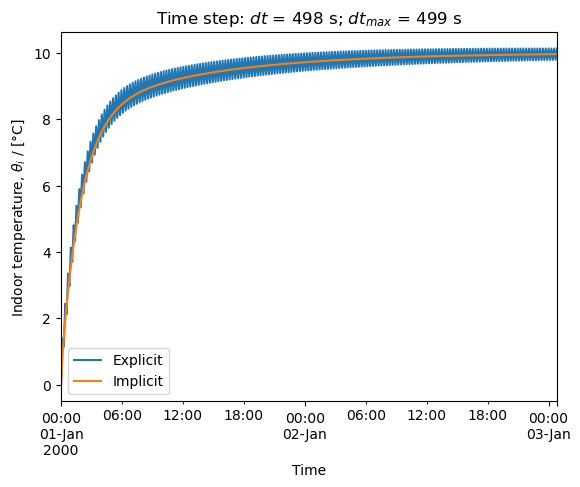

In [18]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / [°C]')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dtmax:.0f} s')
plt.show()